In [1]:
using CSV
using DataFrames
using DSP
using FileIO
using GZip
using JLD2
using KernelDensity
using LinearAlgebra
using NPZ
using ProgressMeter
using PyPlot
using Random
using Statistics
using SparseArrays

base_path = "/Volumes/SLOT256/COVID-19/"

"/Volumes/SLOT256/COVID-19/"

In [2]:
function load_population(path::AbstractString)
    ages = Vector{UInt8}()
    genders = BitVector()
    household_ids = Vector{UInt32}()
    GZip.open(path, "r") do io
        for row in CSV.Rows(io)
            push!(ages, parse(Float64, row.age))
            push!(genders, parse(Bool, row.gender))
            push!(household_ids, parse(UInt32, row.household_id))
        end
    end
    ages, genders, household_ids
end

function compress_households(households::SparseMatrixCSC{T, Ti}) where {T<:Real, Ti<:Integer}
    num_ages, num_households = size(households)
    @assert num_ages < num_households
    
    household2count = Dict{SparseVector{UInt8, Ti}, UInt32}()
    sizehint!(household2count, num_households)
    
    @showprogress for i in 1:num_households
        vec = households[:,i]
        count = get(household2count, vec, 0)
        household2count[vec] = count +1
    end
    
    empty_household = spzeros(T, num_ages)
    if(haskey(household2count, empty_household))
        delete!(household2count, empty_household)
    end
    
    I = Vector{Ti}()
    J = Vector{Ti}()
    V = Vector{T}()
    C = Vector{UInt32}()
    @showprogress for (i,(k,v)) in enumerate(household2count)    
        is, vs = findnz(k)
        append!(I, is)
        append!(J, ones(UInt32, length(is))*i)
        append!(V, vs)
        push!(C, v)
    end
    
    C, sparse(I,J,V) |> SparseMatrixCSC{T, UInt32}
end


compress_households (generic function with 1 method)

In [3]:
population_path = "data/wroclaw-population.csv.gz"

individual_age_wro, individual_gender_wro, individual_hh_id_wro = load_population(population_path)
population_wro = DataFrame(
    age=individual_age_wro,
    gender=individual_gender_wro, 
    household_ids=individual_hh_id_wro)

households_wro_all = sparse(population_wro.age.+1, population_wro.household_ids.+1, 1)


household_wro_count, households_wro = households_wro_all |> SparseMatrixCSC{UInt8,UInt32} |> compress_households

save("data/wroclaw-population.jld2", 
    "household_count", household_wro_count, 
    "households", households_wro, 
    "households_all", households_wro_all,
    compress=true)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [4]:
population_path = "data/poland-population.csv.gz"

individual_age_pol, individual_gender_pol, individual_hh_id_pol = load_population(population_path)
population_pol = DataFrame(
    age=individual_age_pol,
    gender=individual_gender_pol, 
    household_ids=individual_hh_id_pol)

households_pol_all = sparse(population_pol.age.+1, population_pol.household_ids.+1, 1)


household_pol_count, households_pol = households_pol_all |> SparseMatrixCSC{UInt8,UInt32} |> compress_households

save("data/poland-population.jld2", 
    "household_count", household_pol_count, 
    "households", households_pol, 
    "households_all", households_pol_all,
    compress=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [5]:
figure(figsize=(10,5))
hist(individual_age, bins=0:100)
xlabel("age")
ylabel("count")

UndefVarError: UndefVarError: individual_age not defined

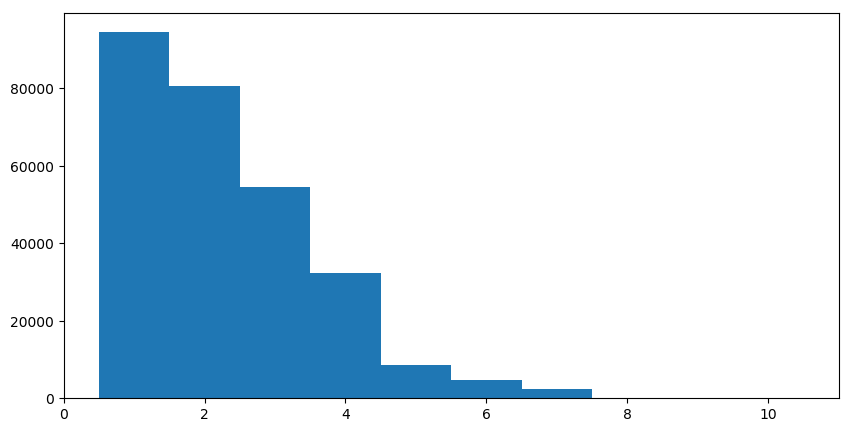

([94629.0, 80612.0, 54403.0, 32402.0, 8472.0, 4766.0, 2383.0, 0.0, 0.0, 0.0], [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x151569320>, PyObject <matplotlib.patches.Rectangle object at 0x151569128>, PyObject <matplotlib.patches.Rectangle object at 0x151569978>, PyObject <matplotlib.patches.Rectangle object at 0x151569cc0>, PyObject <matplotlib.patches.Rectangle object at 0x151569fd0>, PyObject <matplotlib.patches.Rectangle object at 0x15157c390>, PyObject <matplotlib.patches.Rectangle object at 0x15157c6d8>, PyObject <matplotlib.patches.Rectangle object at 0x15157ca20>, PyObject <matplotlib.patches.Rectangle object at 0x15157cd68>, PyObject <matplotlib.patches.Rectangle object at 0x15157ce80>])

In [6]:
figure(figsize=(10,5))
hist( sum(households_wro_all, dims=1)', bins=0.5:10.5)

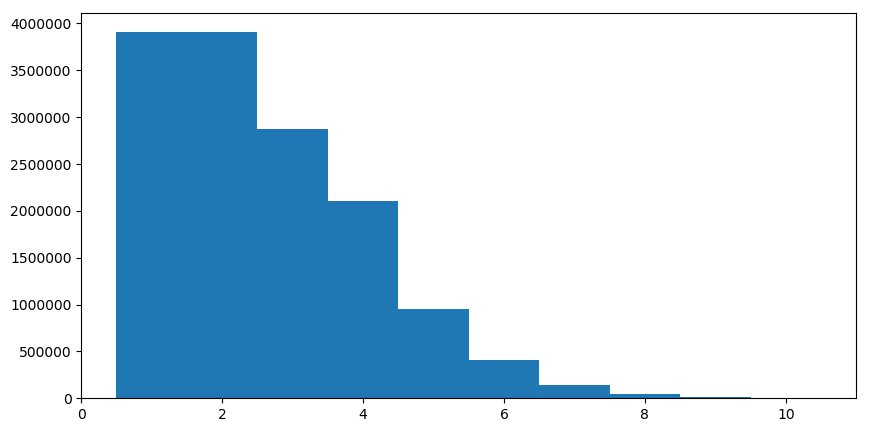

([3.91038e6, 3.910099e6, 2.874404e6, 2.105065e6, 954456.0, 412812.0, 143911.0, 44004.0, 15604.0, 7205.0], [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x158372080>, PyObject <matplotlib.patches.Rectangle object at 0x158369e48>, PyObject <matplotlib.patches.Rectangle object at 0x158372668>, PyObject <matplotlib.patches.Rectangle object at 0x1583729b0>, PyObject <matplotlib.patches.Rectangle object at 0x158372cf8>, PyObject <matplotlib.patches.Rectangle object at 0x158372e10>, PyObject <matplotlib.patches.Rectangle object at 0x15837c3c8>, PyObject <matplotlib.patches.Rectangle object at 0x15837c710>, PyObject <matplotlib.patches.Rectangle object at 0x15837ca58>, PyObject <matplotlib.patches.Rectangle object at 0x15837cda0>])

In [7]:
figure(figsize=(10,5))
hist( sum(households_pol_all, dims=1)', bins=0.5:10.5)

In [8]:
function make_severity_df()::DataFrame
    arr = [
    0.004081632653061225, 0.006270210077735186, 0.8454333254812944, 0.1442148317879093,
    0.004081632653061225, 0.006270210077735186, 0.8454333254812944, 0.1442148317879093,
    0.00816326530612245, 0.006244512495449387, 0.8419684348030924, 0.1436237873953359,
    0.026530612244897958, 0.006128873375163287, 0.8263764267511833, 0.14096408762875562,
    0.07346938775510203, 0.005833351178876588, 0.78653018395186, 0.13416707711416154,
    0.163265306122449, 0.005268004368588989, 0.7103025890314154, 0.12116410047754676,
    0.3020408163265306, 0.00439428657087179, 0.5924963059725464, 0.10106859113005119,]

    arr = collect(reshape(arr, 4,7)')

    arr = vcat(
        repeat(arr[1,:]', 21),
        repeat(arr[2,:]', 20),
        repeat(arr[3,:]', 10),
        repeat(arr[4,:]', 10),
        repeat(arr[5,:]', 10),
        repeat(arr[6,:]', 10),
        repeat(arr[7,:]', 20)
        )

    DataFrame(
        age=0:100, 
        critical=arr[:,1], 
        asymptomatic=arr[:,2], 
        mild=arr[:,3],
        severe=arr[:,4]
    )
end
severity = make_severity_df()
CSV.write(base_path * "severity.csv", severity)

"/Volumes/SLOT256/COVID-19/severity.csv"

In [9]:
t0_dist = npzread(base_path * "incubation_period_distribution.npy")
t0, t0_counts = countuniquesorted(t0_dist)
t0_prob = t0_counts // sum(t0_counts)
plot(t0, t0_prob)
xlabel("time")
ylabel("probability")
xlim(left=0)
ylim(bottom=0)

CSV.write(base_path*"t0_dist.csv", DataFrame(t=t0, counts=t0_counts, prob=Float32.(t0_prob)))

UndefVarError: UndefVarError: countuniquesorted not defined

In [10]:
t1_dist = npzread(base_path*"t1_distribution.npy")
t1, t1_counts = countuniquesorted(t1_dist)
t1_prob = t1_counts // sum(t1_counts)
plot(t1, t1_prob)
xlabel("time")
ylabel("probability")
xlim(left=0)
ylim(bottom=0)

CSV.write(base_path*"t1_dist.csv", DataFrame(t=t1, counts=t1_counts, prob=Float32.(t1_prob)))
dot(t1, t1_counts./sum(t1_counts)) |> display


UndefVarError: UndefVarError: countuniquesorted not defined

In [11]:
t2_dist = npzread(base_path * "t1_t2_distribution.npy")
t2, t2_counts = countuniquesorted(t2_dist)
t2_prob = t2_counts // sum(t2_counts)
plot(t2, t2_prob)
xlabel("time")
ylabel("probability")
xlim(left=0)
ylim(bottom=0)
CSV.write(base_path*"t2_dist.csv", DataFrame(t=t2, counts=t2_counts, prob=Float32.(t2_prob)))

UndefVarError: UndefVarError: countuniquesorted not defined

In [12]:
t01_prob = DSP.conv(t0_prob, t1_prob)
t01 = (minimum(t0)+minimum(t1)):(maximum(t0)+maximum(t1))
plot(t01, t01_prob)
sum(t01_prob)

UndefVarError: UndefVarError: t0_prob not defined

In [13]:
length(t0_prob), length(t2_prob)
t02_prob = DSP.conv(t0_prob, t2_prob)
t2
#length(t0),length(t2)
#t02 = (minimum(t0)+minimum(t2)):(maximum(t0)+maximum(t2))
#plot(t02, t02_prob)

UndefVarError: UndefVarError: t0_prob not defined

In [14]:
function make_dist(
        samples::AbstractArray{T} where T<:Real, 
        times::AbstractVector{T} where T<:Real; bandwidth::Real=0.5)
    dist = kde(vec(samples), bandwidth=bandwidth)
    p = pdf(dist, times)
    p./sum(p)
end

make_dist (generic function with 1 method)

In [15]:
function make_sum_dist(samples1, samples2, times; bandwidth=0.5)
    samples = (vec(samples1) .+ vec(samples2)')[:]
    dist = kde(samples, bandwidth=0.5)
    p = pdf(dist, times)
    p./sum(p)
end

make_sum_dist (generic function with 1 method)

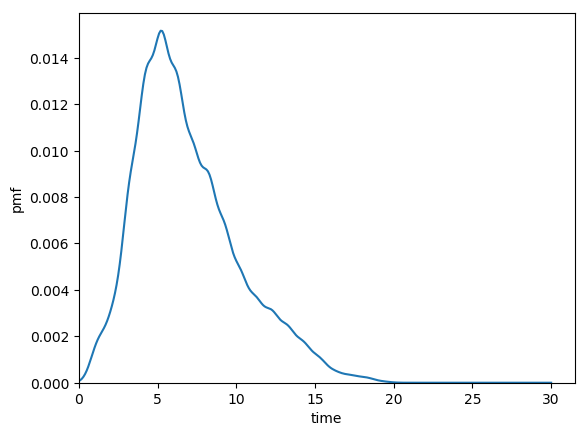

"/Volumes/SLOT256/COVID-19/t01_dist"

In [16]:
t01 = 0:0.1:30
t01_prob = make_dist(t0_dist.+t1_dist', t01, bandwidth=0.5)
plot(t01,t01_prob)
xlim(left=0)
ylim(bottom=0)
xlabel("time")
ylabel("pmf")
CSV.write(base_path*"t01_dist", DataFrame(t=t01, prob=t01_prob))

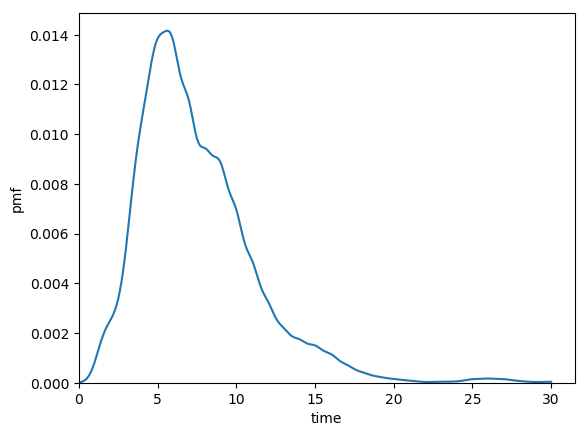

"/Volumes/SLOT256/COVID-19/t02_dist"

In [17]:
t02 = 0:0.1:30
t02_prob = make_dist(t0_dist.+t2_dist', t02, bandwidth=0.5)
plot(t02,t02_prob)
xlim(left=0)
ylim(bottom=0)
xlabel("time")
ylabel("pmf")
CSV.write(base_path*"t02_dist", DataFrame(t=t02, prob=t02_prob))

"mean is 5.704969121639186"

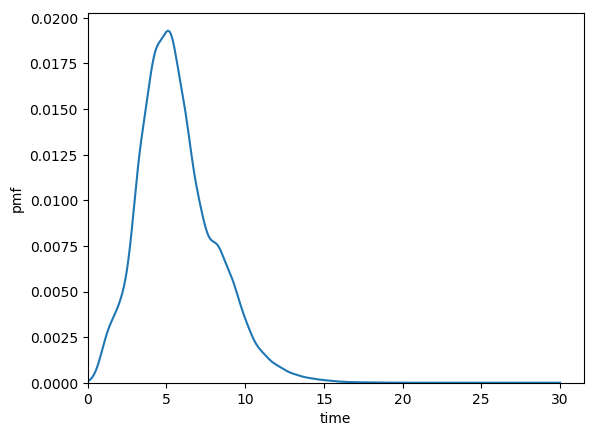

In [18]:
tc = 0:0.1:30

tc_prob = make_dist(t0_dist'.+min.(t1_dist, t2_dist')[:], tc, bandwidth=0.5)
plot(tc, tc_prob)
xlim(left=0)
ylim(bottom=0)
xlabel("time")
ylabel("pmf")
CSV.write(base_path*"tc_dist.csv", DataFrame(t=tc, prob=tc_prob))
display("mean is $(dot(tc, tc_prob))")

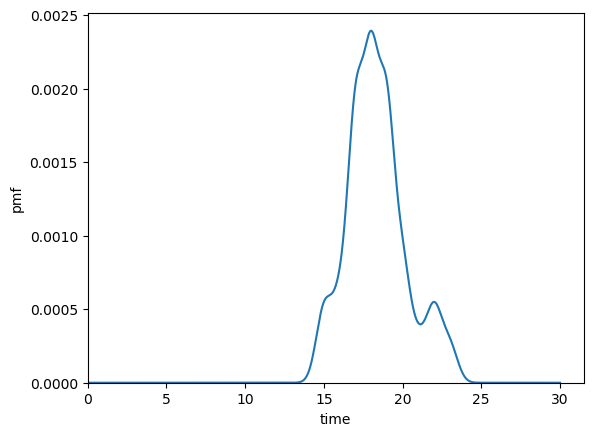

"/Volumes/SLOT256/COVID-19/t0q_dist"

In [19]:
t0q = 0:0.01:30
t0q_prob = make_sum_dist(t0_dist, [14], t0q, bandwidth=0.1)
plot(t0q,t0q_prob)
xlim(left=0)
ylim(bottom=0)
xlabel("time")
ylabel("pmf")
CSV.write(base_path*"t0q_dist", DataFrame(t=t0q, prob=t0q_prob))

In [20]:
population_path = base_path *"aggregated_population.csv"
function load_population(path::AbstractString)
    ages = Vector{UInt8}()
    genders = BitVector()
    household_ids = Vector{Int32}()
    for row in CSV.Rows(path)
        push!(ages, parse(Float64, row.age))
        push!(genders, parse(Bool, row.gender))
        push!(household_ids, parse(Int32, row.household_index))
    end
    ages, genders, household_ids
end
individual_age, individual_gender, individual_hh_id = load_population(population_path)


(UInt8[0x07, 0x2f, 0x16, 0x03, 0x03, 0x52, 0x3a, 0x26, 0x41, 0x3e  …  0x55, 0x29, 0x27, 0x2b, 0x23, 0x42, 0x39, 0x36, 0x2b, 0x45], Bool[0, 1, 0, 0, 0, 0, 1, 1, 1, 0  …  0, 0, 1, 1, 1, 0, 0, 0, 0, 1], Int32[1, 1, 1, 2, 2, 2, 2, 2, 2, 3  …  14377934, 14377935, 14377935, 14377936, 14377936, 14377937, 14377938, 14377939, 14377939, 14377940])

In [21]:
ages = minimum(individual_age):maximum(individual_age)

0x00:0x55

In [22]:
num_ages, num_households = size(households)
num_hh_sizes = 10 # 
hh_size = sum(households, dims=1)
is_singular = hh_size .<= 1
is_nonsingular

UndefVarError: UndefVarError: households not defined

In [23]:
!is_singular

UndefVarError: UndefVarError: is_singular not defined

In [24]:
phi = ones(num_ages, num_hh_sizes)
n = (0:100)' # horizontal vector
t_inf = (0:10) .+ 0.25 # vertical vector

for hh_size in 1:num_hh_sizes
    for (i,age) in enumerate(ages)
        exp.(-t_inf, )
        #phi[i, hh_size] = 
    end
end

UndefVarError: UndefVarError: num_ages not defined